# **IE 643: Feed Forward Neural Network Demo**

In this demo, we will see how to build a Multi-layered perceptron (Feed Forward Neural Network or FFNN) from scratch.

# Importing the basic libaries -

In [70]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1000)

# **Loading the Data-**

We will be using MNIST Dataset for the classification problem. MNIST dataset contains grayscale images of handwritten digits of the size 28*28. We will be building a neural network to classify these images.

The MNIST database of handwritten digits, has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image. 

Source- http://yann.lecun.com/exdb/mnist/

In [71]:
from keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print(f'Train: X - {X_train.shape}, y - {Y_train.shape}')
print(f'Test: X - {X_test.shape}, y - {Y_test.shape}')

Train: X - (60000, 28, 28), y - (60000,)
Test: X - (10000, 28, 28), y - (10000,)


#### Displaying an image from the dataset

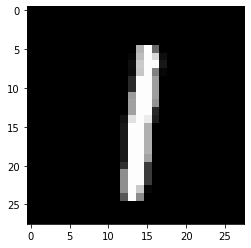



Label in dataset: 1


In [72]:
plt.imshow(X_train[40],cmap='gray')
plt.show()
print(f"\n\nLabel in dataset: {Y_train[40]}")

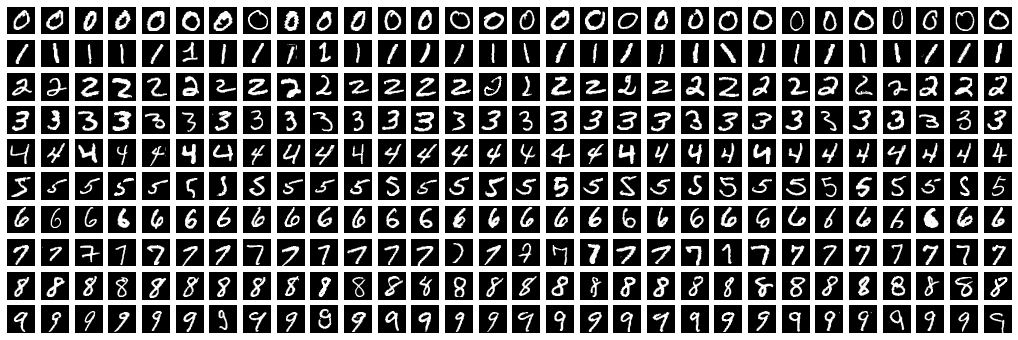

In [73]:
# Sample images for all digits

digits = np.unique(Y_train)
M = 30
dim = 28
fig, axs = plt.subplots(len(digits), M, figsize=(18,6))

for i,d in enumerate(digits):
    for j in range(M):
        axs[i,j].imshow(X_train[Y_train==d][j].reshape((dim,dim)), cmap='gray')
        axs[i,j].axis('off')

In [74]:
#Displaying the contents of 41th image (the choice of index 41 is random here)
X_train[40]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, 178, 255, 105,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

As you can see here, each image is a (28x28) 2d numpy array and hence contains 784 individual pixel values (in grayscale).

In [75]:
#displaying the contents of Y_train for 41st image 
Y_train[40]

1

In [76]:
unique, counts = np.unique(Y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 5923]
 [   1 6742]
 [   2 5958]
 [   3 6131]
 [   4 5842]
 [   5 5421]
 [   6 5918]
 [   7 6265]
 [   8 5851]
 [   9 5949]]


In [77]:
# flattening single example 
example = X_train[40].reshape((-1))
print(type(example))
print("Shape:", example.shape)

<class 'numpy.ndarray'>
Shape: (784,)


# **Pre-processing:**

**Flattening the input values-** Because we are using a simple FFNN, it would be better to convert all the input images of size ${28*28}$ to a size of ${784*1}$ i.e to convert each input from a 2D array to a 1D array.

In [78]:
# flattening the input

X_train_flattened = X_train.reshape((X_train.shape[0], -1))
X_test_flattened = X_test.reshape((X_test.shape[0], -1))

print(f"Shapes - Train: {X_train_flattened.shape}, Test: {X_test_flattened.shape}")

Shapes - Train: (60000, 784), Test: (10000, 784)


**Normalizing input values:**

We often need to normalize the input values into a convinient range. Let us see what is the current range of pixel values:

In [79]:
print("Minimum pixel value =", X_train_flattened.min())
print("Maximum pixel value =", X_train_flattened.max())

Minimum pixel value = 0
Maximum pixel value = 255


As the pixel values lies between the range 0 and 255, we want to normalize the input such that values of the pixels lies in the range (0,1). So, to normalize, we will divide each input values by the maximum pixel value which in this case is 255. 

**Normalizing the dataset:** 

In [80]:
X_normalized_train = np.round(X_train_flattened/X_train_flattened.max(), 3)
X_normalized_test = np.round(X_test_flattened/X_train_flattened.max(), 3)

print("Minimum pixel value =", X_normalized_train.min())
print("Maximum pixel value =", X_normalized_train.max())

Minimum pixel value = 0.0
Maximum pixel value = 1.0


**Normalized and flattened data can still be visaulized just like original data-**

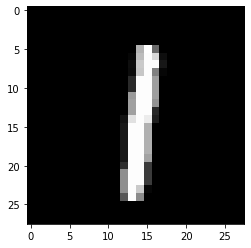

In [81]:
# normalized and flattened data can still be visualized as original data
plt.imshow(X_normalized_train[40].reshape(28,28), cmap='gray')
plt.show()

So, we can see that normalizing does not effect the nature of data. So, we will use this normalized and flattened layer as the input to our neural network.

# **Creating datasets for binary and multiclass classification-**

## **Binary Classification problem-**

MNIST dataset has 10 different target classes, each representing one of the digits from 0-9. Let's consider digits '**0**' and '**1**' for binary classification. We will take only these inputs drom the original dataset-

**Creating the dataset-**

In [82]:
train_idx = np.where((Y_train==0) | (Y_train==1))
X_train_bin = X_normalized_train[train_idx]
Y_train_bin = Y_train[train_idx]

test_idx = np.where((Y_test==0) | (Y_test==1))
X_test_bin = X_normalized_test[test_idx]
Y_test_bin = Y_test[test_idx]

print(f'Trainset shapes - X: {X_train_bin.shape}, Y: {Y_train_bin.shape}')
print(f'Testset shapes - X: {X_test_bin.shape}, Y: {Y_test_bin.shape}')

print(f'\nTrain statistics - 0: {(Y_train_bin==0).sum()}, 1: {(Y_train_bin==1).sum()}')
print(f'Test statistics - 0: {(Y_test_bin==0).sum()}, 1: {(Y_test_bin==1).sum()}')

Trainset shapes - X: (12665, 784), Y: (12665,)
Testset shapes - X: (2115, 784), Y: (2115,)

Train statistics - 0: 5923, 1: 6742
Test statistics - 0: 980, 1: 1135


We now have only 0's and 1's in the newly created subset of the dataset. As we can see that count of 0's and 1's is quite even. So, the dataset is quite evenly balanced.

**Splitting the training dataset-**

Often it is observed that training a model for a large number of epochs leads to the model overfitting very much to the training data set. To tackle this issue, we need a validation dataset to keep track of the 'validation performance'. So, we will now split the current training dataset (of 11344 instances) into a training set and validation set.

In [83]:
from sklearn.model_selection import train_test_split

We can use this library to split our data. 

In general, a split of 90-10, 80-20, 67-33 etc. is used. You can choose your own value as it is always a tradeoff. 

We will go with 80-20 split.

In [84]:
X_train_bin, X_val_bin, Y_train_bin, Y_val_bin = train_test_split(X_train_bin, Y_train_bin, test_size=0.2, random_state = 1)

In [85]:
print("Instances in new train-set:", len(Y_train_bin))
print("Instances in val-set:", len(Y_val_bin))
print("\nCount of 0s and 1s in train-set:", (Y_train_bin==0).sum(), (Y_train_bin==1).sum())
print("Count of 0s and 1s in val-set:", (Y_val_bin==0).sum(), (Y_val_bin==1).sum())

Instances in new train-set: 10132
Instances in val-set: 2533

Count of 0s and 1s in train-set: 4743 5389
Count of 0s and 1s in val-set: 1180 1353


In [86]:
# Traspose feature matrices as per our model requirement

X_train_bin, X_val_bin, X_test_bin = X_train_bin.T, X_val_bin.T, X_test_bin.T
print(f'Shapes - {X_train_bin.shape, X_val_bin.shape, X_test_bin.shape}')

Shapes - ((784, 10132), (784, 2533), (784, 2115))


# **Building the Neural Net class:** 

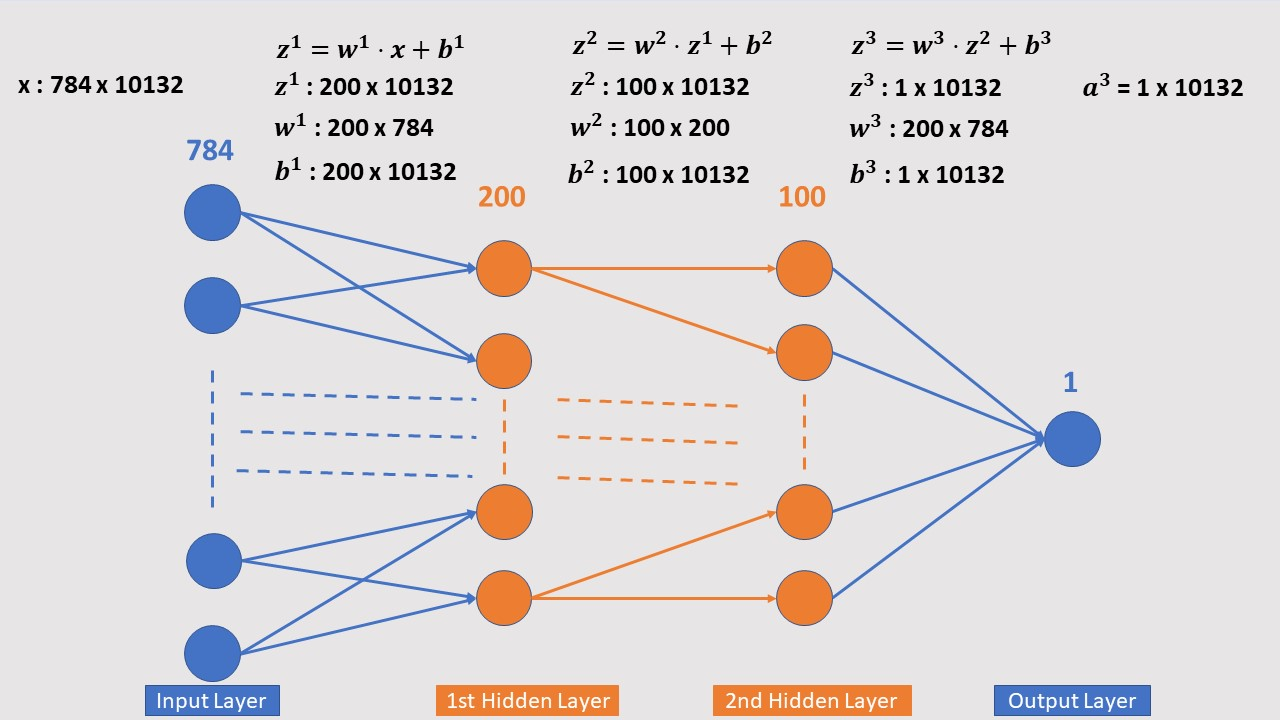

In [87]:
class Neural_Network():
    def __init__(self, neurons, Activations, initialization='randn'):
        """Define the NN design parameters
        Args:
            neurons (int array): list of numbers listing neurons for each layer
            Activations (str array): list of activations to be used for hidden and output layers
            initialization (str, optional): Choose weight initialization from
             uniform or normal distribution. Defaults to 'randn'.
        """
        
        self.inputSize = neurons[0] # Number of neurons in input layer
        self.outputSize = neurons[-1] # Number of neurons in output layer
        self.layers = len(neurons)
        self.weights = [] # weights for each layer
        self.biases = [] # biases in each layer 
        self.layer_activations = [] # activations in each layer
        
        if initialization == 'rand':
            self.initializer = np.random.rand
        elif initialization == 'randn':
            self.initializer = np.random.randn
        else:
            raise ValueError("initialization must be 'rand' or 'randn'")
        for i in range(len(neurons)-1):
            self.weights.append(self.initializer(neurons[i+1],neurons[i])) # weight matrix between layer i and layer i+1
            self.biases.append(self.initializer(neurons[i+1],1))
            self.layer_activations.append(Activations[i]) # activations for each layer

    # Activation Functions and their Derivatives

    def sigmoid(self, z):
        """returns result of the sigmoid activation function on input z."""                 
        return 1.0/(1.0+np.exp(-z))
    
    def sigmoidPrime(self,z):
        """returns derivative of sigmoid activation function applied on input z."""
        sigma = self.sigmoid(z)
        return np.multiply(sigma,1-sigma)
    
    def tanh(self, z):
        """returns result of the tanh sigmoid activation function on input z."""                 
        return np.tanh(z)
    
    def tanhPrime(self,x):
        """returns derivative of hyperbolic tan activation function applied on input z."""
        tan = self.tanh(x)
        return 1-np.square(tan)
                          
    def stanh(self,z):
        tan = self.tanh(z)
        return np.multiply(z,tan)
    
    def stanhPrime(self,z):
        return np.multiply(z,self.tanhPrime(z)) + self.tanh(z)

    def linear(self, z):
        """returns result of the linear activation function on input z."""                                    
        return z
    
    def linearPrime(self,z):
        """returns derivative of linear activation function applied on input z."""                                                      
        return np.ones(z.shape)

    def ReLU(self,z):
        """returns result of the ReLU activation function on input z."""                  
        return np.maximum(z,0)
    
    def ReLUPrime(self,z):
        """returns derivative of ReLU activation function applied on input z."""
        return (z>0)*1
    
    def aReLU(self,z,a=0.5):
        return np.where(z<0,a*z,z)
    
    def aReLUPrime(self,z,a=0.5):
        return np.where(z<0,a,1)

    def EXU(self,z,b=1.05,u=1.67):
        return np.where(z>=0,b*z,b*u*(np.exp(z)-1))

    def EXUPrime(self,z,b=1.05,u=1.67):
        return np.where(z>=0,b,b*u*np.exp(z))

    def softmax(self, z):
        """returns result of the softmax activation function on input z."""
        return np.exp(z)/(np.sum(np.exp(z),axis=0))
    
    # Loss Functions

    def lossSE(self, predicted, actual):
        """Implementation of Squared-error loss function."""
        return np.mean(0.5*((predicted-actual)**2))
    
    def lossCE(self, predicted, actual):
        """Implementation of Cross-Entropy loss function."""
        return (-1/actual.shape[1])*np.sum(np.multiply(actual,np.log(predicted)))
    
    def forward(self, a):
        """Defines forward pass of the NN

        Args:
            a (array): input of size self.inputSize

        Returns:
            (final) a (array): output of forward pass
            layer_wise_z (list): output of each layer
            activations (list): layer-wise activations
        """
        layer_wise_z = []
        activations = [a] # store the input as the input layer activation
        for i, model_para in enumerate(zip(self.biases, self.weights)):
            b, w = model_para[0], model_para[1]
            z = np.dot(w,a) + b
            if self.layer_activations[i] == 'sigmoid':
                a = self.sigmoid(z)
            elif self.layer_activations[i] == 'relu':
                a = self.ReLU(z)
            elif self.layer_activations[i] == 'tanh':   
                a = self.tanh(z)
            elif self.layer_activations[i] == 'linear':
                a = self.linear(z)
            elif self.layer_activations[i] == 'stanh':
                a = self.stanh(z)
            elif self.layer_activations[i] == 'arelu':
                a = self.aReLU(z)
            elif self.layer_activations[i] == 'exu':
                a = self.EXU(z)    
            elif self.layer_activations[i] == 'softmax':
                a = self.softmax(z)
            layer_wise_z.append(z)    
            activations.append(a)
        return a, layer_wise_z, activations
        
    def backward(self, x, y, zs, activations):
        """backward pass to calculate gradient of loss w.r.t. NN parameters

        Args:
            x (array): input
            y (array): ouputs from forward pass
            zs (list): layerwise intermediate outputs from forward pass
            activations (list): layerwise activations from forward pass

        Returns:
            [tuple]: gradients with respect to bias and weight parameters respectively
        """
        
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        final_z = zs[-1] # has shape m x 10132 from above figure
        n = final_z.shape[1] # number of training samples    
        delta = activations[-1] - y # error gradient wrt activation

        # derivative of final activation wrt z
        if self.layer_activations[-1] == 'sigmoid':
            phi_ = self.sigmoidPrime(final_z)
        elif self.layer_activations[-1] == 'tanh':
            phi_ = self.tanhPrime(final_z)
        elif self.layer_activations[-1] == 'linear':
            phi_ = self.linearPrime(final_z)
        elif self.layer_activations[-1] == 'relu':
            phi_ = self.ReLUPrime(final_z)
        elif self.layer_activations[-1] == 'arelu':
            phi_ = self.aReLUPrime(final_z)
        elif self.layer_activations[-1] == 'stanh':
            phi_ = self.stanhPrime(final_z)
        elif self.layer_activations[-1] == 'exu':
            phi_ = self.EXUPrime(final_z)
        elif self.layer_activations[-1] == 'softmax':
            phi_ = 1
        
        V = delta*phi_ # error gradient wrt z
        #print('For this epoch, norm of V at output: '+str(np.linalg.norm(V)))
        grad_b[-1] = np.sum(V, axis=1, keepdims=True)/n
        grad_w[-1] = np.dot(V, activations[-2].T)/n
        
        #Vs = [np.linalg.norm(V)]

        for l in range(2, self.layers):
            z = zs[-l]
            # derivative of hidden layer activation wrt z
            if self.layer_activations[-l] == 'sigmoid':
                phi_ = self.sigmoidPrime(z)
            elif self.layer_activations[-l] == 'tanh':
                phi_ = self.tanhPrime(z)
            elif self.layer_activations[-l] == 'linear':
                phi_ = self.linearPrime(z)
            elif self.layer_activations[-l] == 'ReLU':
                phi_ = self.ReLUPrime(z)
            elif self.layer_activations[-l] == 'arelu':
                phi_ = self.aReLUPrime(z)
            elif self.layer_activations[-l] == 'stanh':
                phi_ = self.stanhPrime(z)
            elif self.layer_activations[-l] == 'exu':
                phi_ = self.EXUPrime(z)
            V = phi_ * np.dot(self.weights[-l+1].T, V)
            #print('At this layer, norm of V is '+str(np.linalg.norm(V)))
            #Vs.append(np.linalg.norm(V))
            grad_b[-l] = np.sum(V, axis=1, keepdims=True)/n
            grad_w[-l] = np.dot(V, activations[-l-1].T)/n

        #print('')
        #plt.plot(Vs)
        #plt.ylabel('Error Gradient wrt z')
        #plt.xlabel('nth layer from output')
        return (grad_b, grad_w)                 

    def update_parameters(self, grads, lr):
        """update the NN parameters using the gradients
        Args:
            grads (list): gradients obtained from backward pass
            lr (float): learning rate of NN
        """
        grad_b, grad_w = grads[0], grads[1]
        for i in range(len(self.weights)):
            self.weights[i] -= lr*grad_w[i] 
            self.biases[i] -= lr*grad_b[i]

    def error(self, X, Y, errors):  
        """Appends loss to error list"""
        y = np.squeeze(self.forward(X)[0])
        errors.append(self.loss(y, Y))

    def copy_params(self):
        """Returns a copy of current NN parameters"""
        weights = [w.copy() for w in self.weights]
        biases = [b.copy() for b in self.biases]
        return (weights, biases)
                    
    def train(self, X, Y, lr = 1e-3, max_epochs = 1000, patience=5, batch_size = None,
              n_classes=10, onehotencoded=False, loss_func='SE', Xval=None, Yval=None, verbose=True):
        """Function for training our Neural Network

        Args:
            X (ndarray): feature matrix of training data,
             Shape: (n,m) where n is no. of features and m is no. of samples.
            Y (ndarray): ground truth of training data, NOT one-hot-encoded. Shape: (1,m).
            lr (float or function, optional): constant learning rate or scheduler function.
             Defaults to 1e-3 constant lr.
            max_epochs (int, optional): epoch cap for training. Defaults to 1000.
            patience (int, optional): patience parameter for early stopping. Defaults to 5.
            batch_size (int, optional): mini-batch size. Defaults to full-batch GD if not provided.
            n_classes (int, optional): no. of classes for multi-class classification required if
            one-hot encoding is set to True. Defaults to 10.
            onehotencoded (bool, optional): Defaults to False.
            loss_func (str, optional): Choose from 'SE' and 'CE' loss functions. Defaults to 'SE'.
            Xval (ndarray, optional): Validation data feature matrix. Defaults to None.
            Yval (ndarray, optional): Validation data ground truth. Defaults to None.
            verbose (bool, optional): If True, displays logs and progress of training. Defaults to True.

        Returns:
            [list/tuple]: lists of train-set and validation-set losses seen over the traning process.
        """
        
        if onehotencoded:
            # a method for creating one hot encoded labels 
            def onehotencoding(Y, n):
                # one-hot encoding of class i is just the ith column of the identity 
                # matrix of size n where n is the total number of classes. so below 
                # code uses Y (a 1d array) for indexing into the identity matrix.
                return np.eye(n)[Y].T 

            Y = onehotencoding(Y, n_classes)
            if Yval is not None:
                Yval = onehotencoding(Yval, n_classes)

        # Below code ensures that Y is 2-dimensional even when one-hot encoding is not
        # performed, so our same code works for training NN for both tasks.  
        Y = np.expand_dims(Y,0) if len(Y.shape) == 1 else Y
        Yval = np.expand_dims(Yval,0) if (Yval is not None and len(Yval.shape) == 1) else Yval
        
        if loss_func == 'SE':
            self.loss = self.lossSE
        elif loss_func == 'CE':
            self.loss = self.lossCE
            
        train_errors=[]
        if Xval is not None:
            val_errors=[]
        i, j, v = 0, 0, np.inf
        best_params = self.copy_params()
        
        if batch_size is not None:
            if batch_size > len(X[0]):
                raise ValueError("invalid mini-batch size. Must be smaller than dataset length")
        else:
            batch_size = len(X[0])

        #LR control function

        if isinstance(lr, (float, int)):# constant Ir arg is passed to train get_ir lambda x: 1r # we return a function object which returns the same ir at every epoc elif callable(lr): # function in arg is passed to train
           get_lr =lambda X: lr # the function is then used to get in for a particular epoch else: raise ValueError('param Ir can only be a number or a scheduler function")
        elif callable(lr):
          get_lr =lr
        else:
          raise ValueError('param lr can only be a number or a scheduler function')

        grad_w_norms = []

        while j < patience:

            # Shuffle Dataset
            idx = np.arange(len(X[0]))
            np.random.shuffle(idx)
            X1 = np.take(X,idx,axis=-1) 
            Y1 = np.take(Y,idx,axis=-1)

            for q in range(0,len(X1[0]),batch_size):
                start, end = q, min(len(X1[0]), q+batch_size)
                train_x = X1[:, start:end] 
                train_y = Y1[:,start:end]
                out, dot_prod_z, activations_a = self.forward(train_x)
                grads = self.backward(train_x, train_y, dot_prod_z, activations_a) # find the gradients using backward pass
                self.update_parameters(grads, get_lr(i))
            
            grad_w = grads[1]
            layer_wise_norms = []
            for grad in grad_w:
                layer_wise_norms.append(np.linalg.norm(grad))
            grad_w_norms.append(layer_wise_norms)

            i += 1 # increment epoch count

            self.error(X, Y, train_errors)
            if Xval is not None:
                self.error(Xval, Yval, val_errors)

                if val_errors[-1] < v:
                    j = 0 # reset patience counter
                    v = val_errors[-1] # update best loss
                    best_params = self.copy_params() # save params
                else:
                    j += 1 # increment patience counter

            if verbose and i%5 == 0:
                log = f"Epoch {i}..............Loss on train = {train_errors[-1]}"
                if Xval is not None:
                    log += f", Loss on val = {val_errors[-1]}"
                print(log)
                
            if i >= max_epochs:
                break # stop if epoch threshold crossed
        
        if Xval is not None:
            if i >= max_epochs and verbose:
                print("Reached Epoch Cap without convergence....Terminating")
            elif verbose:
                print("Early Stopping .............. Returning best weights")

            self.weights, self.biases = best_params # reset to best params
                    
        if verbose:
            x = np.arange(1, len(train_errors)+1)
            plt.plot(x, train_errors, label="Loss on Train")
            if Xval is not None:
                plt.plot(x, val_errors, label="Loss on Val")
            plt.legend()
            plt.title(f"{loss_func} - Learning Rate = {lr}")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.show()
        if Xval is not None:           
            return (train_errors, val_errors, grad_w_norms)
        return train_errors, grad_w_norms
        
    def predict(self, x):
      out, _, _ = self.forward(x)
      pred = np.squeeze(out)
      if len(pred.shape) > 1:
        pred = np.argmax(pred, axis=0)
      else:
        pred = (pred > 0.5).astype(int)
      return pred      

**Creating a MLP (Feed forward NN) model instance for our Binary classification task :**

Let's now create a simple feed-forward neural network. 

* Number of input neurons = 784.
* Number of output layer neurons = 1.

The number of hidden layers and number of neurons in each hidden layer can be decided by the user.

## 3 new activations with sigmoid act at last layer

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


Epoch 5..............Loss on train = 0.04212906712140895, Loss on val = 0.04163487785605491
Epoch 10..............Loss on train = 0.013945542283470754, Loss on val = 0.01478424994276974
Epoch 15..............Loss on train = 0.010215160369544358, Loss on val = 0.009454355878745047
Epoch 20..............Loss on train = 0.010215160018783061, Loss on val = 0.00944742251150946
Epoch 25..............Loss on train = 0.010215159953932084, Loss on val = 0.00944405326075511
Epoch 30..............Loss on train = 0.010215159925864626, Loss on val = 0.009441808464923708
Epoch 35..............Loss on train = 0.010215159909903295, Loss on val = 0.009440150862777013
Epoch 40..............Loss on train = 0.010215159899524203, Loss on val = 0.009438874031056619
Epoch 45..............Loss on train = 0.010215159892148227, Loss on val = 0.009437867131475168
Epoch 50..............Loss on train = 0.010215159886541082, Loss on val = 0.009437061027705623
Epoch 55..............Loss on train = 0.0102151598820768

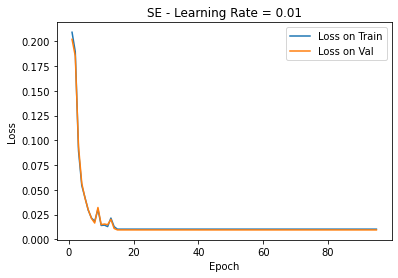

In [ ]:
D_in, H1, H2, H3, D_out = 784, 200, 50, 10, 1 
neurons = [D_in, H1, H2, H3, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['stanh','stanh','stanh','sigmoid'] # activations in each layer except input
nn_bin = Neural_Network(neurons, activation_functions)
train_losses, val_losses, grad_w_norms = nn_bin.train(X_train_bin, Y_train_bin, batch_size=32, lr=1e-2, max_epochs=200, Xval = X_val_bin, Yval = Y_val_bin)

In [ ]:
grad_w_norms

[[1.0421941049617572e-94,
  9.904169731838148e-95,
  1.0872853743500049e-94,
  5.1521091489580166e-95],
 [9.62231907771549e-51,
  9.448844185848236e-51,
  1.1558411556241618e-50,
  6.131254738318544e-51],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [3.246742209261167e-23,
  3.0645063713127474e-23,
  3.868786019060065e-23,
  2.4108760298844673e-23],
 [1.5147749960813224e-84,
  1.681519187264025e-84,
  1.961855827667098e-84,
  1.0709769860274403e-84],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [1.5981244203044623e-10,
  1.689476360031821e-10,
  2.0369347570532868e-10,
  1.1811095563024753e-10],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [3.8360979567878655e-149,
  3.7104026717530883e-149,
  4.114300230920251e-149,
  1.7955315074365313e-149],
 [1.5436177460251707e-135,
  1.5520424247258402e-135,
  1.912543004237099e-135,
  1.1312907447023515e-135],
 [0.0, 0.0, 0.0, 0.0],
 [6.516158050543238e-26,
  6.371241691157812e-26,
  6.37000606

For each epoch, L2 norm of gradient of error wrt weights at each layer is recorded. Being very tiny or 0 indicates vanishing gradient issue.

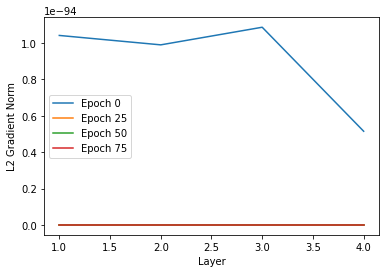

In [ ]:
for i in range(0,95,25):
  plt.plot([1,2,3,4], grad_w_norms[i], label = 'Epoch '+str(i))
plt.ylabel('L2 Gradient Norm')
plt.xlabel('Layer')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


Epoch 5..............Loss on train = 0.26593959731543626, Loss on val = 0.2670746150809317
Early Stopping .............. Returning best weights


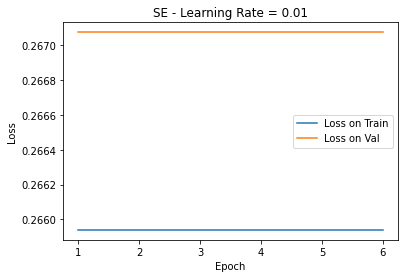

In [107]:
# Retraining
D_in, H1, H2, H3, D_out = 784, 200, 50, 10, 1 
neurons = [D_in, H1, H2, H3, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['stanh','stanh','stanh','sigmoid'] # activations in each layer except input
nn_bin = Neural_Network(neurons, activation_functions)
train_losses, val_losses, grad_w_norms = nn_bin.train(X_train_bin, Y_train_bin, batch_size=32, lr=1e-2, max_epochs=200, Xval = X_val_bin, Yval = Y_val_bin)

In [108]:
grad_w_norms

[[0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: overflow encountered in multiply


Epoch 5..............Loss on train = 0.26781484231967084, Loss on val = 0.2686537702201097
Epoch 10..............Loss on train = 0.26781484210396644, Loss on val = 0.2686537702190826
Epoch 15..............Loss on train = 0.267814841827819, Loss on val = 0.26865377021782355
Epoch 20..............Loss on train = 0.2678148414618772, Loss on val = 0.2686537702162354
Epoch 25..............Loss on train = 0.2678148409542745, Loss on val = 0.26865377021415465
Epoch 30..............Loss on train = 0.2678148402040796, Loss on val = 0.26865377021128234
Epoch 35..............Loss on train = 0.2678148389860764, Loss on val = 0.26865377020699827
Epoch 40..............Loss on train = 0.2678148366786765, Loss on val = 0.26865377019974734
Epoch 45..............Loss on train = 0.2678148307598403, Loss on val = 0.2686537701840484
Epoch 50..............Loss on train = 0.2678147920746694, Loss on val = 0.2686537701130262
Epoch 55..............Loss on train = 0.26707461521263987, Loss on val = 0.2678641926

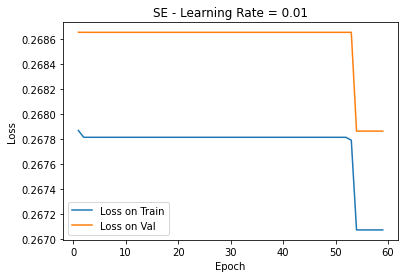

In [ ]:
D_in, H1, H2, H3, D_out = 784, 200, 50, 10, 1
neurons = [D_in, H1, H2, H3, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['exu','exu','exu','sigmoid'] # activations in each layer except input
nn_bin = Neural_Network(neurons, activation_functions)
train_losses, val_losses, grad_w_norms = nn_bin.train(X_train_bin, Y_train_bin, batch_size=32, lr=1e-2, max_epochs=200, Xval = X_val_bin, Yval = Y_val_bin)

In [ ]:
grad_w_norms

[[0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [2.382053750968508e-13,
  2.2683708671465954e-13,
  2.9443556959563215e-13,
  1.7534878844804838e-13],
 [1.9977575163804516e-48,
  1.7802419830879317e-48,
  1.7536793183480558e-48,
  1.7749077122518327e-48],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [1.2826435468375969e-11,
  1.3766002987203027e-11,
  2.1587254714397148e-11,
  2.516532567104044e-11],
 [1.4267501530966661e-58,
  1.4591439154400353e-58,
  2.437615733786965e-58,
  1.742546399123077e-58],
 [1.2934577061938651e-117,
  1.2410283616267446e-117,
  1.713304229853691e-117,
  5.778209551492599e-118],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [1.0339556723021674e-71,
  9.976855151482653e-72,
  1.194881123061959e-71,
  1.221992794089366e-71],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [2.854956914976324e-90,
  2.886027020418401e-90,
  2.829043217755071e-90,
  3.927477618789489e-90]

For each epoch, L2 norm of gradient of error wrt weights at each layer is recorded. Being very tiny or 0 indicates vanishing gradient issue.

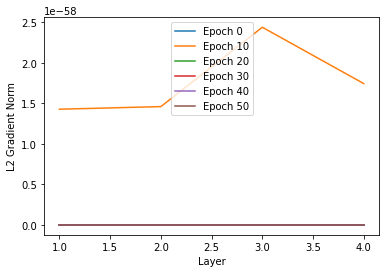

In [ ]:
for i in range(0,55,10):
  plt.plot([1,2,3,4], grad_w_norms[i], label = 'Epoch '+str(i))
plt.ylabel('L2 Gradient Norm')
plt.xlabel('Layer')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


Epoch 5..............Loss on train = 0.023575442674550157, Loss on val = 0.016979327926332003
Epoch 10..............Loss on train = 0.013373441839458397, Loss on val = 0.008880384666236361
Early Stopping .............. Returning best weights


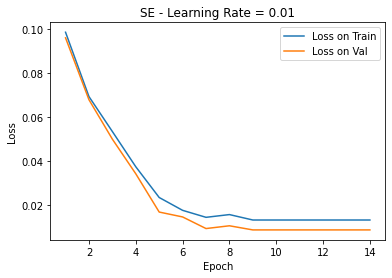

In [ ]:
D_in, H1, H2, H3, D_out = 784, 200, 50, 10, 1
neurons = [D_in, H1, H2, H3, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['arelu','arelu','arelu','sigmoid'] # activations in each layer except input
nn_bin = Neural_Network(neurons, activation_functions)
train_losses, val_losses, grad_w_norms = nn_bin.train(X_train_bin, Y_train_bin, batch_size=32, lr=1e-2, max_epochs=200, Xval = X_val_bin, Yval = Y_val_bin)

In [ ]:
grad_w_norms

[[7.688398114995241e-119,
  8.803487967037543e-119,
  8.589983197742863e-119,
  5.070761924921406e-119],
 [1.930702633688254e-13,
  2.1261477344505228e-13,
  2.0735890916210506e-13,
  2.3761546251771174e-13],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [1.7848164456927642,
  1.9316346601591154,
  1.5802785979958822,
  1.126564898729894],
 [3.841237120873192e-148,
  4.2417772376148004e-148,
  4.448403628602539e-148,
  2.461607227075935e-148],
 [4.609288357321395e-65,
  4.780541350633066e-65,
  3.521975226874782e-65,
  3.4410758428886166e-65],
 [6.186335516965143e-51,
  6.328585087317369e-51,
  4.5335387840969057e-51,
  4.1004776810518963e-51],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [1.232126680738027e-55,
  1.2730943529645758e-55,
  8.791263561582178e-56,
  5.900727767685002e-56]]

For each epoch, L2 norm of gradient of error wrt weights at each layer is recorded. Being very tiny or 0 indicates vanishing gradient issue.

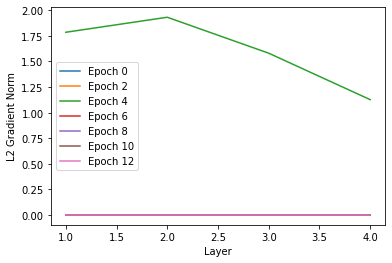

In [ ]:
for i in range(0,14,2):
  plt.plot([1,2,3,4], grad_w_norms[i], label = 'Epoch '+str(i))
plt.ylabel('L2 Gradient Norm')
plt.xlabel('Layer')
plt.legend()

##3 new activations with linear act at last layer

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply


Epoch 5..............Loss on train = nan, Loss on val = nan
Early Stopping .............. Returning best weights


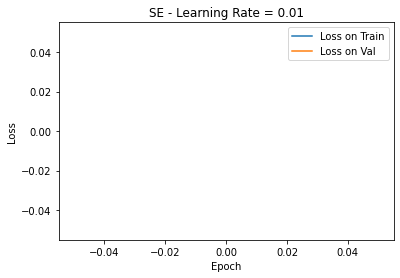

In [ ]:
D_in, H1, H2, H3, D_out = 784, 200, 50, 10, 1 
neurons = [D_in, H1, H2, H3, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['stanh','stanh','stanh','linear'] # activations in each layer except input
nn_bin = Neural_Network(neurons, activation_functions)
train_losses, val_losses, grad_w_norms = nn_bin.train(X_train_bin, Y_train_bin, batch_size=32, lr=1e-2, max_epochs=200, Xval = X_val_bin, Yval = Y_val_bin)

NaN values have been returned. They most often mean that the network is suffering from exploding gradient issue.

In [ ]:
grad_w_norms

[[nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan]]

Epoch 5..............Loss on train = nan, Loss on val = nan
Early Stopping .............. Returning best weights


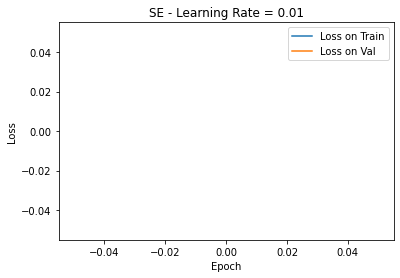

In [ ]:
D_in, H1, H2, H3, D_out = 784, 200, 50, 10, 1
neurons = [D_in, H1, H2, H3, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['arelu','arelu','arelu','linear'] # activations in each layer except input
nn_bin = Neural_Network(neurons, activation_functions)
losses = nn_bin.train(X_train_bin, Y_train_bin, batch_size=32, lr=1e-2, max_epochs=200, Xval = X_val_bin, Yval = Y_val_bin)

NaN values have been returned. They most often mean that the network is suffering from exploding gradient issue.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: overflow encountered in multiply


Epoch 5..............Loss on train = nan, Loss on val = nan
Early Stopping .............. Returning best weights


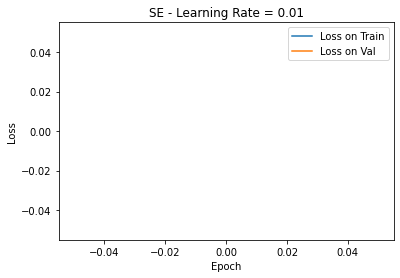

In [ ]:
D_in, H1, H2, H3, D_out = 784, 200, 50, 10, 1
neurons = [D_in, H1, H2, H3, D_out] # list of number of neurons in the layers sequentially.
activation_functions = ['exu','exu','exu','linear'] # activations in each layer except input
nn_bin = Neural_Network(neurons, activation_functions)
losses = nn_bin.train(X_train_bin, Y_train_bin, batch_size=32, lr=1e-2, max_epochs=200, Xval = X_val_bin, Yval = Y_val_bin)

NaN values have been returned. They most often mean that the network is suffering from exploding gradient issue.

## Investigating activations & their derivatives which feature in backpropagation

In [90]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))
    
def sigmoidPrime(z):
    sigma = sigmoid(z)
    return np.multiply(sigma,1-sigma)
    
def tanh(z):
    return np.tanh(z)
    
def tanhPrime(x):
    tan = tanh(x)
    return 1-np.square(tan)
                          
def stanh(z):
    tan = tanh(z)
    return np.multiply(z,tan)
    
def stanhPrime(z):
    return np.multiply(z,tanhPrime(z)) + tanh(z)

def linear(z):
    return z
    
def linearPrime(z):
    return np.ones(z.shape)

def ReLU(z):
    return np.maximum(z,0)
    
def ReLUPrime(z):
    return (z>0)*1
    
def aReLU(z,a=0.5):
    return np.where(z<0,a*z,z)
    
def aReLUPrime(z,a=0.5):
    return np.where(z<0,a,1)

def EXU(z,b=1.05,u=1.67):
    return np.where(z>=0,b*z,b*u*(np.exp(z)-1))

def EXUPrime(z,b=1.05,u=1.67):
    return np.where(z>=0,b,b*u*np.exp(z))

Reference: https://www.analyticsvidhya.com/blog/2021/06/the-challenge-of-vanishing-exploding-gradients-in-deep-neural-networks/

###Output Layer Activations

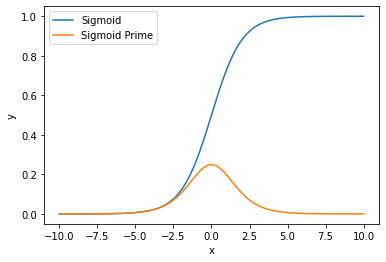

In [92]:
x = np.linspace(-10,10,100)
sigma = sigmoid(x)
sigmaPrime = sigmoidPrime(x)
plt.plot(x,sigma)
plt.plot(x,sigmaPrime)
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['Sigmoid','Sigmoid Prime'])

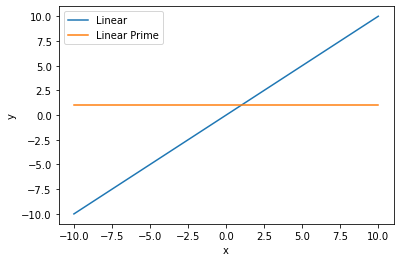

In [93]:
x = np.linspace(-10,10,100)
lin = linear(x)
linPrime = linearPrime(x)
plt.plot(x,lin)
plt.plot(x,linPrime)
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['Linear','Linear Prime'])

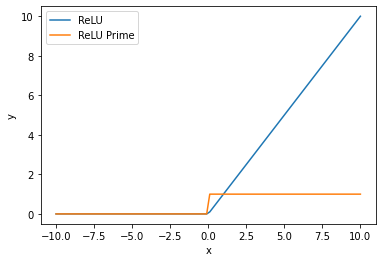

In [101]:
x = np.linspace(-10,10,100)
relu = ReLU(x)
reluPrime = ReLUPrime(x)
plt.plot(x,relu)
plt.plot(x,reluPrime)
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['ReLU','ReLU Prime'])

###Hidden Layer Activations

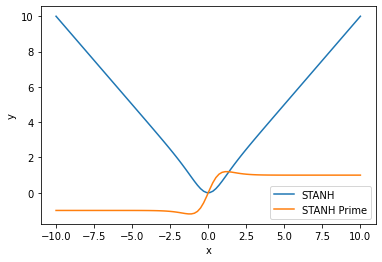

In [100]:
x = np.linspace(-10,10,100)
st = stanh(x)
stPrime = stanhPrime(x)
plt.plot(x,st)
plt.plot(x,stPrime)
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['STANH','STANH Prime'])

In [112]:
stPrime

array([-1.00000008, -1.00000011, -1.00000017, -1.00000025, -1.00000036,
       -1.00000053, -1.00000077, -1.00000113, -1.00000165, -1.0000024 ,
       -1.00000351, -1.00000511, -1.00000744, -1.00001083, -1.00001574,
       -1.00002286, -1.00003318, -1.00004809, -1.00006964, -1.00010071,
       -1.00014547, -1.00020983, -1.00030222, -1.00043459, -1.00062384,
       -1.00089382, -1.00127796, -1.00182302, -1.00259397, -1.00368052,
       -1.00520565, -1.00733636, -1.01029679, -1.01438331, -1.01998007,
       -1.02757126, -1.03774247, -1.05115626, -1.06847451, -1.09018076,
       -1.1162264 , -1.14539089, -1.1742281 , -1.19553023, -1.19651311,
       -1.15760273, -1.05380893, -0.86141801, -0.57090603, -0.20065442,
        0.20065442,  0.57090603,  0.86141801,  1.05380893,  1.15760273,
        1.19651311,  1.19553023,  1.1742281 ,  1.14539089,  1.1162264 ,
        1.09018076,  1.06847451,  1.05115626,  1.03774247,  1.02757126,
        1.01998007,  1.01438331,  1.01029679,  1.00733636,  1.00

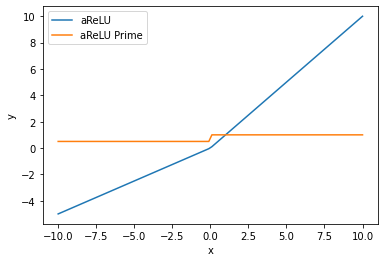

In [102]:
x = np.linspace(-10,10,100)
arelu = aReLU(x)
areluPrime = aReLUPrime(x)
plt.plot(x,arelu)
plt.plot(x,areluPrime)
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['aReLU','aReLU Prime'])

In [111]:
areluPrime

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ])

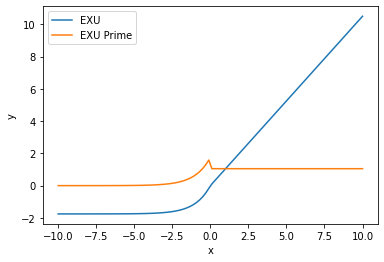

In [103]:
x = np.linspace(-10,10,100)
exu = EXU(x)
exuPrime = EXUPrime(x)
plt.plot(x,exu)
plt.plot(x,exuPrime)
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['EXU','EXU Prime'])

In [110]:
exuPrime

array([7.96087768e-05, 9.74310112e-05, 1.19243158e-04, 1.45938450e-04,
       1.78610089e-04, 2.18596018e-04, 2.67533706e-04, 3.27427207e-04,
       4.00729231e-04, 4.90441579e-04, 6.00238075e-04, 7.34615013e-04,
       8.99075284e-04, 1.10035372e-03, 1.34669292e-03, 1.64818074e-03,
       2.01716347e-03, 2.46875137e-03, 3.02143748e-03, 3.69785495e-03,
       4.52570384e-03, 5.53888553e-03, 6.77889096e-03, 8.29649981e-03,
       1.01538599e-02, 1.24270323e-02, 1.52091059e-02, 1.86140100e-02,
       2.27811793e-02, 2.78812642e-02, 3.41231190e-02, 4.17623549e-02,
       5.11118074e-02, 6.25543473e-02, 7.65585600e-02, 9.36979340e-02,
       1.14674347e-01, 1.40346806e-01, 1.71766629e-01, 2.10220493e-01,
       2.57283130e-01, 3.14881807e-01, 3.85375258e-01, 4.71650269e-01,
       5.77239904e-01, 7.06468179e-01, 8.64627140e-01, 1.05819358e+00,
       1.29509427e+00, 1.58503056e+00, 1.05000000e+00, 1.05000000e+00,
       1.05000000e+00, 1.05000000e+00, 1.05000000e+00, 1.05000000e+00,
      

###Q1. (d),(e),(f),(g),(h)<br>
1. The backpropagation terms which form the error gradient wrt weights as seen in code include products of weights, hidden layer activation derivatives (phi_), delta (output activation - actual output) and output activation derivative (final phi_).
2. 1.aReLU prime outputs a (taken 0.5) or 1.<br>2. For most inputs, output of STANH Prime is around -1 or 1.<br>3. However, as input of exuPrime becomes more negative, it yields very low values.<br>
3. So unlike the former two, exuPrime will more often cause vanishing gradient issue because of low phi_ values
4. For all experiments, a neural network with input layer (mnist pixel values), 3 hidden layers (with varying no of neurons specifically 200, 50, 10) and output layer with 1 neuron (mnist binary classification) is considered. Final activation sigmoid yields probability which is useful for classification.
5. L2 Norm of the error gradient wrt weights at each layer is recorded at each epoch. If it has very low or 0 values then it would indicate vanishing gradient issue. Very slow learning or stagnation in few iterations also indicates the same. On the other hand if these values and all others such as losses are NaN values it would indicate exploding gradient issue caused by large weight values which overflow. The training stops as the weights can no longer be updated.
6. If output activation or its derivative results in very low or high values then the product forming the error gradient thus will be accordingly very low or high and maintain so as we propagate layers towards input as it won't be affected much by aReLU Prime or STANH Prime coming from hidden layers.
7. Thus, sigmoid remains between 0 & 1 but as sigmoid Prime attains very low values away from 0, the error gradient will be very low at the output layer itself and subsequently through the layers vanishing gradient persists which is also observed above.
8. If we change output layer activation to linear which takes high values far away from 0, then it is possible that the z input to linear activation during forward pass is very high so that the final linear activation output is very high and this contributes to delta of error gradient. This might be the reason behind exploding gradient i.e. NaN values observed above. Note: Linear Prime is fixed to be 1 so it won't affect.
9. If ReLU activation is present at output layer: ReLU & ReLU Prime are fixed to be 0 for negative input, ReLU Prime is fixed to be 1 for positive input, while ReLU mimics linear for positive input. So for negative inputs the error gradient would be fixed 0 rather than vanishing while for positive inputs the behaviour is expected to be similar to the linear case. 